In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import applications
from tensorflow.keras import optimizers

In [2]:
datadir='/home/shashimal/Documents/dataset'
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

In [3]:
training_data=[]
def create_training_data():
    for category in categories:
        path = os.path.join(datadir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(96,96))
#                 crop_array = new_array[0:96,35:96]
                training_data.append([new_array,class_num])
            except Exception as e:    
                pass
create_training_data() 

In [4]:
x=[]
y=[]

for features,label in training_data:
    x.append(features)
    y.append(label)
x = np.array(x).reshape(8000,96,96,3)
x.shape

(8000, 96, 96, 3)

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [6]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_train/=255
x_test/=255

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

In [9]:
model1 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))
model2 = applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))

In [22]:
for layer in model1.layers[:20]:
    layer.trainable = False
x1 = model1.output
x1 =  tf.keras.layers.Flatten()(x)
# x1 = tf.keras.layers.Dense(1024, activation="relu")(x)
# x1 = tf.keras.layers.Dropout(0.5)(x)
# x1 = tf.keras.layers.Dense(1024, activation="relu")(x)


In [28]:
for layer in model2.layers[:150]:
    layer.trainable = False
x2 = model2.output
x2 =  tf.keras.layers.Flatten()(x)
# x2 = tf.keras.layers.Dense(1024, activation="relu")(x)
# x2 = tf.keras.layers.Dropout(0.5)(x)
# x2 = tf.keras.layers.Dense(1024, activation="relu")(x)

In [29]:
concatenated = tf.keras.layers.concatenate([x1,x2])
out=tf.keras.layers.Flatten()(concatenated)

In [30]:

x = tf.keras.layers.Dense(1024, activation="relu")(out)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x)   
model_final = tf.keras.models.Model(model1.input,predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [31]:
history=model_final.fit(x_train, y_train,
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 662s 103ms/sample - loss: 2.1084 - acc: 0.1363 - val_loss: 2.0034 - val_acc: 0.2894
Epoch 2/5
6400/6400 [==============================] - 597s 93ms/sample - loss: 2.0213 - acc: 0.1969 - val_loss: 1.9037 - val_acc: 0.2956
Epoch 3/5
6400/6400 [==============================] - 542s 85ms/sample - loss: 1.9480 - acc: 0.2472 - val_loss: 1.7918 - val_acc: 0.3319
Epoch 4/5
6400/6400 [==============================] - 538s 84ms/sample - loss: 1.8528 - acc: 0.2952 - val_loss: 1.6586 - val_acc: 0.4050
Epoch 5/5
6400/6400 [==============================] - 538s 84ms/sample - loss: 1.7476 - acc: 0.3278 - val_loss: 1.5334 - val_acc: 0.3969


In [32]:
score = model_final.evaluate(x_test, y_test, verbose=0)

In [33]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5334487199783324
Test accuracy: 0.396875


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


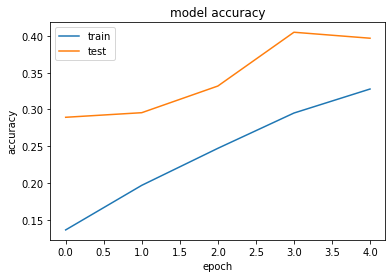

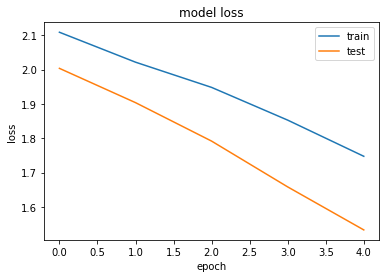

In [34]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
predictions=model_final.predict(x_test)
predictions[10]

array([1.7406090e-01, 8.2465869e-01, 7.4679956e-05, 6.4581633e-05,
       3.0395921e-04, 3.3695229e-05, 7.4848841e-04, 5.4951608e-05],
      dtype=float32)

In [31]:
import numpy as np
np.argmax(predictions[10])

1

In [32]:
y_test[10]

array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)